In [2]:
import numpy as np
import pandas as pd
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import SlopeDescriptor, PAADescriptor, CompoundDescriptor, DerivativeShapeDescriptor, DWTDescriptor
from shapedtw.dtwPlot import dtwPlot
from matplotlib import pyplot as plt
from dtw import dtw
import inspect

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



shape_dtw(x, y, subsequence_width: int,
              shape_descriptor: ShapeDescriptor,
              step_pattern: str = "symmetric2",
              dist_method: str ="euclidean",
              multivariate_version: str = "dependent",
              **kwargs)

#### Compare DTW and shapeDTW on OSUleaf dataset

Reproduce paper experiments

In [3]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

In [4]:
# get params of a function/method
method_to_test = DWTDescriptor
signature = inspect.signature(method_to_test)
parameters = signature.parameters
parameter_names = list(parameters.keys())
print("Noms des arguments de la fonction :", parameter_names)

Noms des arguments de la fonction : ['wave_type', 'mode', 'level']


In [5]:
from aeon.datasets import load_osuleaf
X_test, y_test = load_osuleaf(split="TEST")

In [6]:
# same ts as in the paper example
ts_x = X_test[114][0]
ts_y = X_test[134][0]

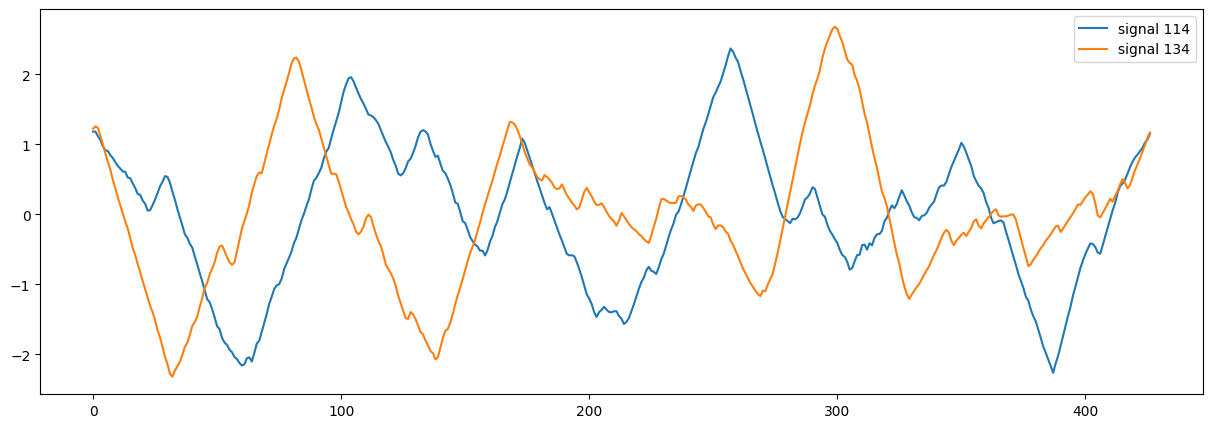

In [7]:
fig, ax = fig_ax()
ax.plot(ts_x, label="signal 114")
ax.plot(ts_y, label="signal 134")
# plt.title(f"DTW: {alignment_dtw.distance:.2f} and shapeDTW: {alignment_shape_dtw.distance:.2f}")
_ = plt.legend()

<Axes: >

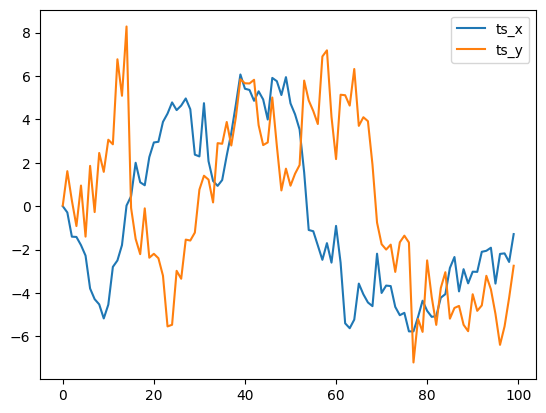

In [8]:
np.random.seed(9)
distortion_factor = 1
ts_x = np.cumsum(randn(100))
ts_y = np.concatenate(
    (
        np.cumsum(randn(15)),
        ts_x[:85]
    )
) + (randn(100)*distortion_factor)

df = pd.DataFrame({"ts_x": ts_x, "ts_y": ts_y})
df.plot()

DTW: 126.27


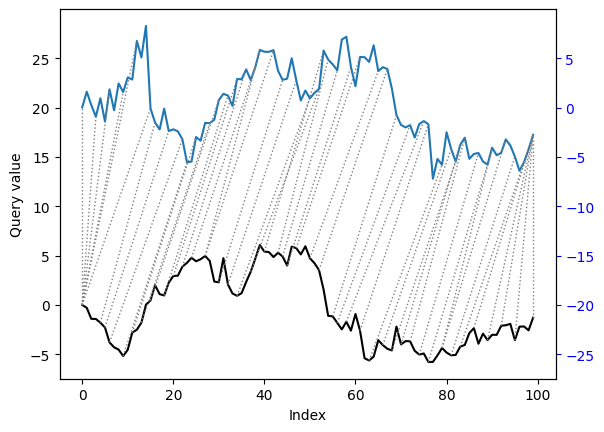

In [9]:
# dtw
alignment_dtw = dtw(ts_x, ts_y, keep_internals=True)
alignment_dtw.plot(type="twoway", offset=20)
print(f"DTW: {alignment_dtw.distance:.2f}")

shapeDTW: 115.40


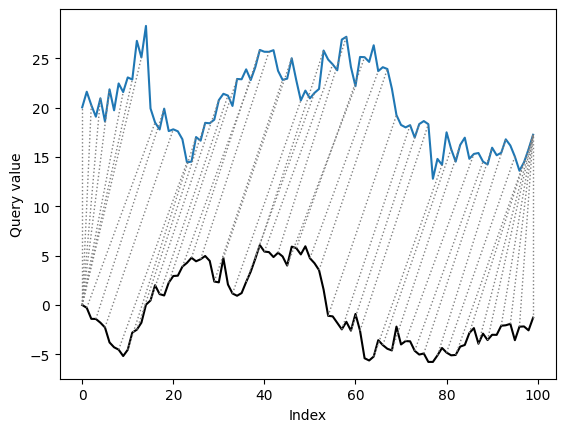

In [10]:
# shapeDTW
slope_descriptor = SlopeDescriptor(slope_window=5)
paa_descriptor = PAADescriptor(piecewise_aggregation_window=5)
compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor],descriptors_weights=[5., 1.])
dwt_descriptor = DWTDescriptor()
derivative_descriptor = DerivativeShapeDescriptor()

shape_dtw_results = shape_dtw(
    x = ts_x,
    y = ts_y,
    subsequence_width = len(ts_x),
    step_pattern = "symmetric1",
    shape_descriptor = derivative_descriptor
)

# distance between shape descriptors of time series, not time series itself
print(f"shapeDTW: {shape_dtw_results.distance:.2f}")
dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 20)

Distance and normalized_distance are distances between raw values of time series, whereas shape_distance and shape_normalized_distance are distances between shape descriptors of time series.

In [11]:
print(round(shape_dtw_results.distance, 2)) #distance between raw time series
print(round(shape_dtw_results.normalized_distance, 2)) #normalized distance between raw time series
print(round(shape_dtw_results.shape_distance, 2)) #distance between shape descriptors of time series, not time series itself
print(round(shape_dtw_results.shape_normalized_distance, 2)) #normalized distance between shape descriptors

115.4
nan
1463.18
nan


## Experiments

- Compare handwritten signatures with DTW and shapeDTW? --> not time series

- Speech recognition
- Dataset : https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

DTW can be used as a comparison module for data matching in speech recognition systems, such as identifying whether two words represent the same word.

The smaller the distance produced, the more similar between the two sound patterns. Both sound patterns are similar, thus the two voices are said to be the same.

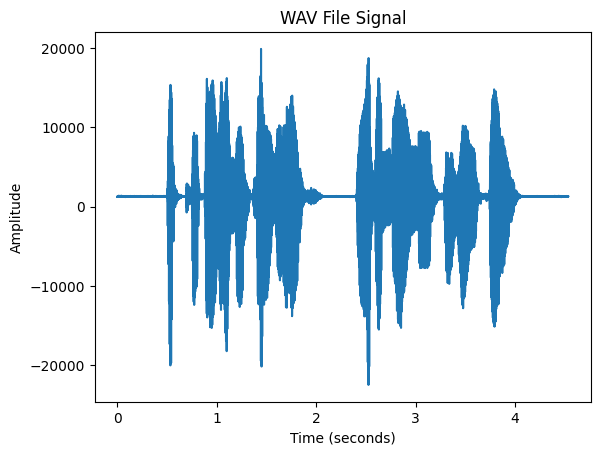

In [80]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import scipy
import librosa
from fastdtw import fastdtw

# Specify the path to your WAV file
wav_file_path = 'data/savee/DC_d10.wav'

# Open the WAV file
with wave.open(wav_file_path, 'rb') as wav_file:
    # Get the audio parameters
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()

    # Read the audio data
    signal = wav_file.readframes(n_frames)
    signal = np.frombuffer(signal, dtype=np.int16)

# Calculate the time axis
time = np.linspace(0, len(signal) / framerate, num=len(signal))

# Plot the signal
plt.plot(time, signal)
plt.title('WAV File Signal') 
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

sample_rate, audio_data = scipy.io.wavfile.read(wav_file_path)
Audio(data=audio_data, rate=sample_rate)

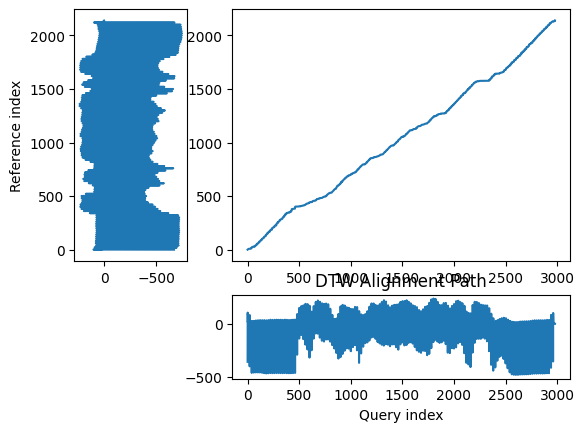

In [81]:
# DTW for speech recognition

#DC, KL, JK, JE
audio_file1 = 'data/savee/DC_a02.wav'
audio_file2 = 'data/savee/KL_a02.wav'

# Load audio files
audio1, sr1 = librosa.load(audio_file1)
audio2, sr2 = librosa.load(audio_file2)

# Extract MFCC features
mfccs1 = librosa.feature.mfcc(y=audio1, sr=sr1).T
mfccs2 = librosa.feature.mfcc(y=audio2, sr=sr2).T

# Flatten MFCC matrices
mfccs1_flat = mfccs1.flatten()
mfccs2_flat = mfccs2.flatten()

# Calculate DTW distance
alignment = dtw(mfccs1_flat, mfccs2_flat, keep_internals=True)
distance = alignment.normalizedDistance

# Plot the alignment path
alignment.plot(type="threeway", offset=-5)

plt.title('DTW Alignment Path')
plt.show()


copmare alignments paths between DTW and shapeDTW

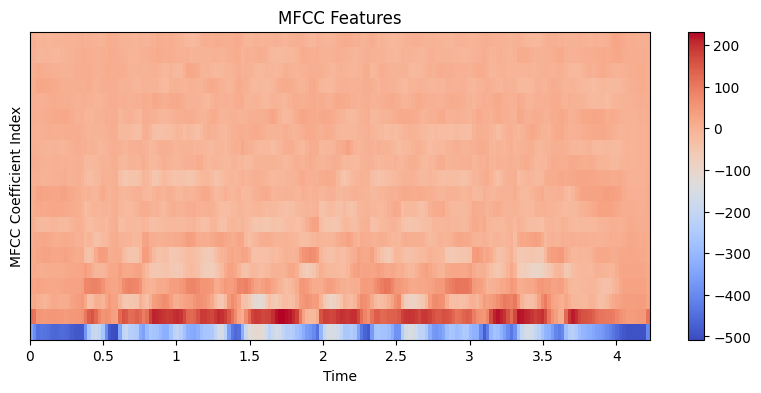

In [79]:
# Visualize MFCC

#DC, KL, JK, JE
audio_file = 'data/savee/JK_d10.wav'

# Load audio file
audio, sr = librosa.load(audio_file)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Plot MFCC features
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC Features')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficient Index')
plt.show()


In [72]:
# shapeDTW for speech recognition
distance, path = fastdtw(mfccs1, mfccs2)

print("DTW Distance:", distance)
print("Optimal Path:", path)

DTW Distance: 80799.05345334113
Optimal Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 1), (9, 2), (10, 3), (11, 4), (12, 5), (13, 6), (14, 7), (15, 8), (16, 9), (17, 10), (18, 11), (19, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 19), (28, 19), (29, 19), (30, 20), (31, 21), (32, 22), (33, 23), (34, 24), (35, 25), (36, 25), (37, 25), (38, 26), (39, 26), (40, 26), (41, 27), (42, 28), (43, 29), (44, 30), (45, 31), (46, 32), (47, 33), (48, 34), (49, 35), (50, 35), (51, 35), (52, 36), (53, 37), (54, 38), (55, 39), (56, 40), (57, 41), (58, 41), (59, 42), (60, 42), (61, 42), (62, 42), (63, 42), (64, 43), (65, 44), (66, 45), (67, 46), (68, 47), (69, 47), (70, 47), (71, 47), (72, 47), (73, 47), (74, 47), (75, 47), (76, 47), (77, 47), (78, 47), (79, 48), (80, 49), (81, 50), (82, 50), (83, 50), (84, 50), (85, 50), (86, 51), (87, 52), (88, 53), (89, 53), (90, 53), (91, 53), (92, 54), (93, 55), (94, 56), (95, 57), (96, 58), (97, 59), 

shapeDTW: 143053.24


<Axes: xlabel='Query index', ylabel='Reference index'>

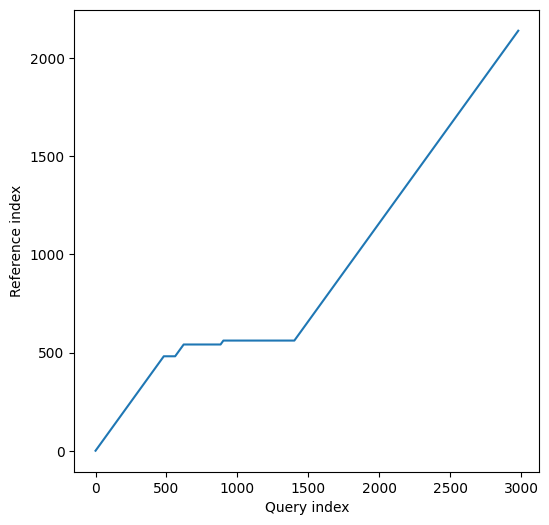

In [87]:
shape_dtw_results = shape_dtw(
    x = mfccs1_flat,
    y = mfccs2_flat,
    subsequence_width = 20,
    step_pattern = "symmetric1",
    shape_descriptor = derivative_descriptor
)

# distance between shape descriptors of time series, not time series itself
print(f"shapeDTW: {shape_dtw_results.distance:.2f}")
dtwPlot(shape_dtw_results)#, plot_type="twoway", yoffset = 20)